In [1]:
import numpy
from galpy.util import bovy_plot
%pylab inline
numpy.random.seed(1)
import copy

/Users/bovy/anaconda/envs/py27/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))

Populating the interactive namespace from numpy and matplotlib


# Harmonic-oscillator M2M

## Mock observations

We sample from a distribution $f(z,v_z) \propto e^{-E/\sigma^2}$ with $\sigma = 0.1$. The gravitational potential is $\Phi(z) = \omega^2 z^2 / 2$, with $\omega = 1.3$. Sampling from $f(z,v_z)$ can be simply done by sampling $E \leftarrow e^{-E/\sigma^2}$ and $\phi \leftarrow \mathrm{Uniform(0,2\pi)}$ and then computing $z = \sqrt{2E}/\omega\,\cos\phi,\ v_z = -\sqrt{2E}\, \sin(\phi)$.

In [2]:
n_mock= 10000
sigma_true= 0.1
omega_true= 1.3
E_mock= numpy.random.exponential(scale=sigma_true**2.,size=n_mock)
phi_mock= numpy.random.uniform(size=n_mock)*2.*numpy.pi
z_mock= numpy.sqrt(2.*E_mock)/omega_true*numpy.cos(phi_mock)
vz_mock= -numpy.sqrt(2.*E_mock)*numpy.sin(phi_mock)

The density distribution is Gaussian as expected:

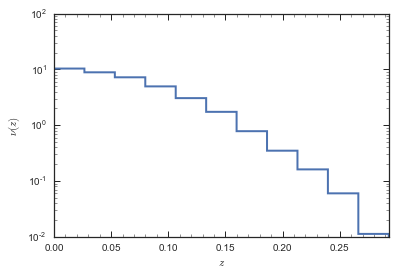

In [3]:
_= bovy_plot.bovy_hist(numpy.fabs(z_mock),bins=11,normed=True,
                       xlabel=r'$z$',ylabel=r'$\nu(z)$',lw=2.,histtype='step')
gca().set_yscale('log')

Now we 'observe' this density distribution from $z_{\mathrm{sun}} = 0.05$:

In [4]:
zsun_true= 0.05
def sph_kernel(r,h):
    out= numpy.zeros_like(r)
    out[(r >= 0.)*(r <= h/2.)]= 1.-6.*(r[(r >= 0.)*(r <= h/2.)]/h)**2.+6.*(r[(r >= 0.)*(r <= h/2.)]/h)**3.
    out[(r > h/2.)*(r <= h)]= 2.*(1-(r[(r > h/2.)*(r <= h)]/h))**3.
    out*= 4./3./h
    return out
def sph_kernel_deriv(r,h):
    out= numpy.zeros_like(r)
    out[(r >= 0.)*(r <= h/2.)]= -12.*r[(r >= 0.)*(r <= h/2.)]/h**2.+18.*r[(r >= 0.)*(r <= h/2.)]**2./h**3.
    out[(r > h/2.)*(r <= h)]= -6./h*(1-(r[(r > h/2.)*(r <= h)]/h))**2.
    out*= 4./3./h
    return out
def epanechnikov_kernel(r,h):
    out= numpy.zeros_like(r)
    out[(r >= 0.)*(r <= h)]= 3./4.*(1.-r[(r >= 0.)*(r <= h)]**2./h**2.)/h
    return out
def epanechnikov_kernel_deriv(r,h):
    out= numpy.zeros_like(r)
    out[(r >= 0.)*(r <= h)]= -3./2.*r[(r >= 0.)*(r <= h)]/h**3.
    return out
if True:
    kernel= epanechnikov_kernel
    kernel_deriv= epanechnikov_kernel_deriv
else:
    kernel= sph_kernel
    kernel_deriv= sph_kernel_deriv
# We only observe the density at a few z
z_obs= numpy.array([0.1,0.15,0.2,-0.1,-0.15,-0.2])
h_obs= 0.025
def compute_dens(z,zsun,z_obs,w=None):
    if w is None: w= numpy.ones_like(z)
    dens= numpy.zeros_like(z_obs)
    for ii,zo in enumerate(z_obs):
        dens[ii]= numpy.sum(w*kernel(numpy.fabs(zo-z+zsun),h_obs))/len(z)
    return dens
dens_obs= compute_dens(z_mock,zsun_true,z_obs)

The observed density is:

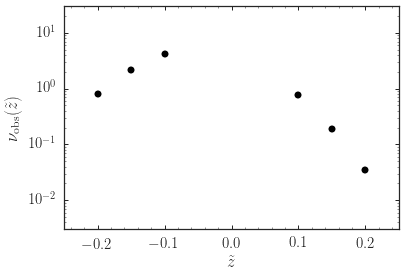

In [5]:
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,xtick_labelsize=15.,ytick_labelsize=15.)
figsize(6,4)
bovy_plot.bovy_plot(z_obs,dens_obs,'ko',semilogy=True,
                   xlabel=r'$\tilde{z}$',ylabel=r'$\nu_{\mathrm{obs}}(\tilde{z})$',
                   xrange=[-.25,0.25],yrange=[0.003,30.])

## Basic M2M fit

Here we perform the basic M2M fit to the observed density assuming we know the potential.

In [6]:
def force_of_change_weights(w_m2m,zsun_m2m,z_m2m,vz_m2m,
                            eps,mu,w_prior,
                            z_obs,dens_obs,
                            h_m2m=0.02,
                            delta_m2m=None):
    """Computes the force of change for all of the weights"""
    delta_m2m_new= numpy.zeros_like(z_obs)
    Wij= numpy.zeros((len(z_obs),len(z_m2m)))
    for ii,zo in enumerate(z_obs):
        Wij[ii]= kernel(numpy.fabs(zo-z_m2m+zsun_m2m),h_m2m)
        delta_m2m_new[ii]= (numpy.sum(w_m2m*Wij[ii])/len(z_m2m)-dens_obs[ii])/dens_obs[ii]
    if delta_m2m is None: delta_m2m= delta_m2m_new
    return (-eps*w_m2m*(numpy.sum(numpy.tile(delta_m2m,(len(z_m2m),1)).T*Wij,axis=0)\
                        +mu*(numpy.log(w_m2m/w_prior)+1.)),delta_m2m_new)
def run_m2m_weights(w_init,A_init,phi_init,
                    omega_m2m,zsun_m2m,
                    z_obs,dens_obs,
                    step=0.001,nstep=1000,
                    eps=0.1,mu=1.,
                    h_m2m=0.02,
                    smooth=None):
    w_out= copy.deepcopy(w_init)
    Q_out= []
    if not smooth is None:
        # Smooth the constraints
        phi_now= phi_init
        z_m2m= A_init*numpy.cos(phi_now)
        vz_m2m= -A_init*omega_m2m*numpy.sin(phi_now) # unnecessary
        dens_init= compute_dens(z_m2m,zsun_m2m,z_obs,w=w_init)
        delta_m2m= (dens_init-dens_obs)/dens_obs
    else:
        delta_m2m= None
    for ii in range(nstep):
        # Compute current (z,vz)
        phi_now= omega_m2m*ii*step+phi_init
        z_m2m= A_init*numpy.cos(phi_now)
        vz_m2m= -A_init*omega_m2m*numpy.sin(phi_now) # unnecessary
        fcw, delta_m2m_new= force_of_change_weights(w_out,zsun_m2m,
                                                    z_m2m,vz_m2m,
                                                    eps,mu,w_init,
                                                    z_obs,dens_obs,h_m2m=h_m2m,
                                                    delta_m2m=delta_m2m)
        w_out+= step*fcw
        w_out/= numpy.sum(w_out)/len(A_init)
        w_out[w_out < 0.]= 10.**-16.
        if not smooth is None:
            Q_out.append(delta_m2m**2.)
        else:
            Q_out.append(delta_m2m_new**2.)
        # Increment smoothing
        if not smooth is None:
            delta_m2m+= step*smooth*(delta_m2m_new-delta_m2m)
    return (w_out,numpy.array(Q_out))

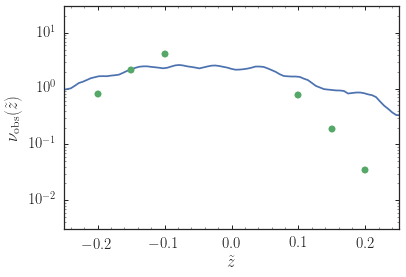

In [7]:
n_m2m= 1000
sigma_init= 0.2
E_m2m= numpy.random.exponential(scale=sigma_init**2.,size=n_m2m)
phi_m2m= numpy.random.uniform(size=n_m2m)*2.*numpy.pi
A_m2m= numpy.sqrt(2.*E_m2m)/omega_true
w_init= numpy.ones(n_m2m)
z_m2m= A_m2m*numpy.cos(phi_m2m)
z_out= numpy.linspace(-0.3,0.3,101)
dens_init= compute_dens(z_m2m,zsun_true,z_out,w_init)
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,xtick_labelsize=15.,ytick_labelsize=15.)
figsize(6,4)
bovy_plot.bovy_plot(z_out,dens_init,'-',semilogy=True,
                   xlabel=r'$\tilde{z}$',ylabel=r'$\nu_{\mathrm{obs}}(\tilde{z})$',
                   xrange=[-.25,0.25],yrange=[0.003,30.])
bovy_plot.bovy_plot(z_obs,dens_obs,'o',semilogy=True,overplot=True)

Run without any smoothing:

In [8]:
step= numpy.pi/3.*10.**-2.
nstep= 30000
eps= 10.**-1.
mu= 0.
h_m2m= 0.025
omega_m2m= omega_true
zsun_m2m= zsun_true
w_out,Q= run_m2m_weights(w_init,A_m2m,phi_m2m,omega_m2m,zsun_m2m,
                         z_obs,dens_obs,nstep=nstep,step=step,mu=mu,eps=eps,h_m2m=h_m2m)

('Velocity dispersions: mock, fit', 0.099155676074897642, 0.10708431031181319)


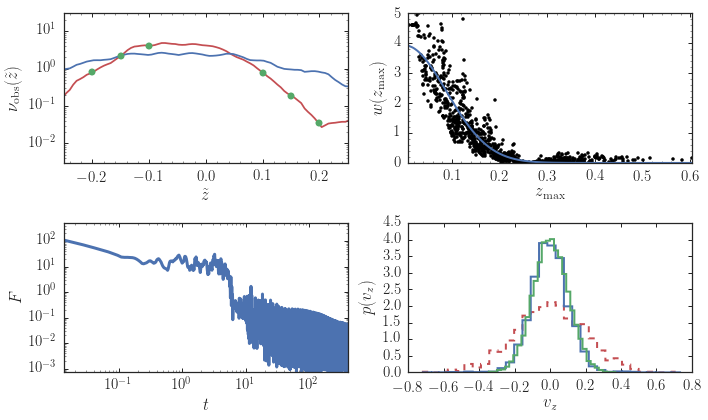

In [9]:
z_m2m= A_m2m*numpy.cos(phi_m2m+nstep*step*omega_m2m)
vz_m2m= -A_m2m*omega_m2m*numpy.sin(phi_m2m+nstep*step*omega_m2m)
z_out= numpy.linspace(-0.3,0.3,101)
dens_final= compute_dens(z_m2m,zsun_true,z_out,w_out)
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,xtick_labelsize=15.,ytick_labelsize=15.)
figsize(10,6)
subplot(2,2,1)
bovy_plot.bovy_plot(z_out,dens_init,'-',semilogy=True,
                   xlabel=r'$\tilde{z}$',ylabel=r'$\nu_{\mathrm{obs}}(\tilde{z})$',
                   xrange=[-.25,0.25],yrange=[0.003,30.],gcf=True)
bovy_plot.bovy_plot(z_obs,dens_obs,'o',semilogy=True,overplot=True)
bovy_plot.bovy_plot(z_out,dens_final,'-',semilogy=True,overplot=True,zorder=0)
subplot(2,2,2)
bovy_plot.bovy_plot(A_m2m,w_out,'k.',xlabel=r'$z_{\mathrm{max}}$',ylabel=r'$w(z_{\mathrm{max}})$',
                   yrange=[0.,5.],gcf=True)
sindx= numpy.argsort(A_m2m)
w_expect= numpy.exp((A_m2m[sindx]*omega_m2m)**2./2.*(1./sigma_init**2.-1./sigma_true**2.))
w_expect/= numpy.sum(w_expect)/len(w_expect)
plot(A_m2m[sindx],w_expect,lw=2.)
subplot(2,2,3)
bovy_plot.bovy_plot(numpy.linspace(0.,1.,nstep)*nstep*step*omega_m2m,numpy.sum(Q,axis=1),lw=3.,
                   loglog=True,xlabel=r'$t$',ylabel=r'$F$',gcf=True)
subplot(2,2,4)
_= hist(vz_m2m,weights=w_out,histtype='step',lw=2.,normed=True,bins=31,zorder=1)
_= hist(vz_mock,histtype='step',lw=2.,normed=True,bins=31,zorder=2)
_= hist(vz_m2m,histtype='step',lw=2.,normed=True,bins=31,ls='--',zorder=0)
xlabel(r'$v_z$')
ylabel(r'$p(v_z)$')
print("Velocity dispersions: mock, fit",numpy.std(vz_mock),\
      numpy.sqrt(numpy.sum(w_out*(vz_m2m-numpy.sum(w_out*vz_m2m)/numpy.sum(w_out))**2.)/numpy.sum(w_out)))
tight_layout()

Run with smoothing:

In [10]:
step= numpy.pi/3.*10.**-2.
nstep= 30000
eps= 10.**-1.
mu= 0.
h_m2m= 0.025
smooth= 10.*10.**-1.
omega_m2m= omega_true
zsun_m2m= zsun_true
w_out,Q= run_m2m_weights(w_init,A_m2m,phi_m2m,omega_m2m,zsun_m2m,
                         z_obs,dens_obs,nstep=nstep,step=step,mu=mu,eps=eps,smooth=smooth,h_m2m=h_m2m)

('Velocity dispersions: mock, fit', 0.099155676074897642, 0.11305666087568628)


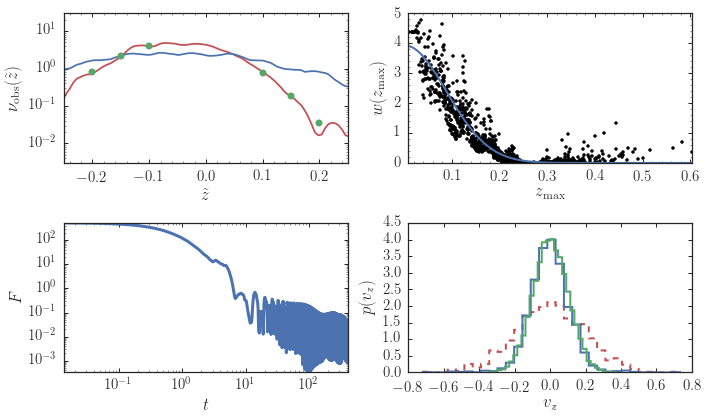

In [11]:
z_m2m= A_m2m*numpy.cos(phi_m2m+nstep*step*omega_m2m)
vz_m2m= -A_m2m*omega_m2m*numpy.sin(phi_m2m+nstep*step*omega_m2m)
z_out= numpy.linspace(-0.3,0.3,101)
dens_final= compute_dens(z_m2m,zsun_true,z_out,w_out)
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,xtick_labelsize=15.,ytick_labelsize=15.)
figsize(10,6)
subplot(2,2,1)
bovy_plot.bovy_plot(z_out,dens_init,'-',semilogy=True,
                   xlabel=r'$\tilde{z}$',ylabel=r'$\nu_{\mathrm{obs}}(\tilde{z})$',
                   xrange=[-.25,0.25],yrange=[0.003,30.],gcf=True)
bovy_plot.bovy_plot(z_obs,dens_obs,'o',semilogy=True,overplot=True)
bovy_plot.bovy_plot(z_out,dens_final,'-',semilogy=True,overplot=True,zorder=0)
subplot(2,2,2)
bovy_plot.bovy_plot(A_m2m,w_out,'k.',xlabel=r'$z_{\mathrm{max}}$',ylabel=r'$w(z_{\mathrm{max}})$',
                   yrange=[0.,5.],gcf=True)
sindx= numpy.argsort(A_m2m)
w_expect= numpy.exp((A_m2m[sindx]*omega_m2m)**2./2.*(1./sigma_init**2.-1./sigma_true**2.))
w_expect/= numpy.sum(w_expect)/len(w_expect)
plot(A_m2m[sindx],w_expect,lw=2.)
subplot(2,2,3)
bovy_plot.bovy_plot(numpy.linspace(0.,1.,nstep)*nstep*step*omega_m2m,numpy.sum(Q,axis=1),lw=3.,
                   loglog=True,xlabel=r'$t$',ylabel=r'$F$',gcf=True)
subplot(2,2,4)
_= hist(vz_m2m,weights=w_out,histtype='step',lw=2.,normed=True,bins=31,zorder=1)
_= hist(vz_mock,histtype='step',lw=2.,normed=True,bins=31,zorder=2)
_= hist(vz_m2m,histtype='step',lw=2.,normed=True,bins=31,ls='--',zorder=0)
xlabel(r'$v_z$')
ylabel(r'$p(v_z)$')
print("Velocity dispersions: mock, fit",numpy.std(vz_mock),\
      numpy.sqrt(numpy.sum(w_out*(vz_m2m-numpy.sum(w_out*vz_m2m)/numpy.sum(w_out))**2.)/numpy.sum(w_out)))
tight_layout()

## Also vary $z_\mathrm{sun}$ during the optimization

In [12]:
def force_of_change_zsun(w_m2m,zsun_m2m,z_m2m,vz_m2m,
                         eps,mu,w_prior,
                         z_obs,dens_obs,
                         h_m2m=0.02,
                         delta_m2m=None):
    """Computes the force of change for all of the weights"""
    out= 0.
    for ii,zo in enumerate(z_obs):
        dWij= kernel_deriv(numpy.fabs(zo-z_m2m+zsun_m2m),h_m2m)*numpy.sign(zo-z_m2m+zsun_m2m)
        out+= delta_m2m[ii]*numpy.sum(w_m2m*dWij)/len(z_m2m)
    return -eps*out
def run_m2m_weights_zsun(w_init,A_init,phi_init,
                        omega_m2m,zsun_m2m,
                        z_obs,dens_obs,
                        step=0.001,nstep=1000,
                        eps=0.1,eps_zo=0.001,mu=1.,
                        h_m2m=0.02,
                        smooth=None):
    w_out= copy.deepcopy(w_init)
    Q_out= []
    if not smooth is None:
        # Smooth the constraints
        phi_now= phi_init
        z_m2m= A_init*numpy.cos(phi_now)
        vz_m2m= -A_init*omega_m2m*numpy.sin(phi_now) # unnecessary
        dens_init= compute_dens(z_m2m,zsun_m2m,z_obs,w=w_init)
        delta_m2m= (dens_init-dens_obs)/dens_obs
    else:
        delta_m2m= None
    for ii in range(nstep):
        # Compute current (z,vz)
        phi_now= omega_m2m*ii*step+phi_init
        z_m2m= A_init*numpy.cos(phi_now)
        vz_m2m= -A_init*omega_m2m*numpy.sin(phi_now) # unnecessary
        fcw, delta_m2m_new= force_of_change_weights(w_out,zsun_m2m,
                                                    z_m2m,vz_m2m,
                                                    eps,mu,w_init,
                                                    z_obs,dens_obs,h_m2m=h_m2m,
                                                    delta_m2m=delta_m2m)
        if smooth is None:
            fcz= force_of_change_zsun(w_out,zsun_m2m,
                                      z_m2m,vz_m2m,
                                      eps_zo,mu,w_init,
                                      z_obs,dens_obs,h_m2m=h_m2m,delta_m2m=delta_m2m_new)
        else:
            fcz= force_of_change_zsun(w_out,zsun_m2m,
                                      z_m2m,vz_m2m,
                                      eps_zo,mu,w_init,
                                      z_obs,dens_obs,h_m2m=h_m2m,delta_m2m=delta_m2m)
        #print(fcz)
        w_out+= step*fcw
        w_out/= numpy.sum(w_out)/len(A_init)
        w_out[w_out < 0.]= 10.**-16.
        zsun_m2m+= step*fcz
        Q_out.append(delta_m2m_new**2.)
        # Increment smoothing
        if not smooth is None:
            delta_m2m= step*smooth*(delta_m2m_new-delta_m2m)
    return ((w_out,zsun_m2m),numpy.array(Q_out))

In [13]:
step= numpy.pi/3.*10.**-2.
nstep= 30000
eps= 10.**-1.
eps_zo= eps/100.
mu= 0.
h_m2m= 0.025
omega_m2m= omega_true
zsun_m2m= zsun_true-0.05
(w_out,zsun_out),Q= run_m2m_weights_zsun(w_init,A_m2m,phi_m2m,omega_m2m,zsun_m2m,
                                         z_obs,dens_obs,nstep=nstep,step=step,mu=mu,eps=eps,h_m2m=h_m2m,eps_zo=eps_zo)

('Velocity dispersions: mock, fit', 0.099155676074897642, 0.10402527994352193)
('Zsun: fit, starting point', 0.050993893007517402, 0.0)


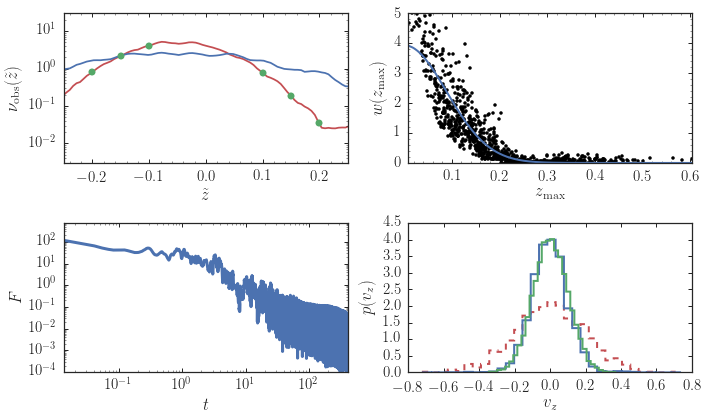

In [14]:
z_m2m= A_m2m*numpy.cos(phi_m2m+nstep*step*omega_m2m)
vz_m2m= -A_m2m*omega_m2m*numpy.sin(phi_m2m+nstep*step*omega_m2m)
z_out= numpy.linspace(-0.3,0.3,101)
dens_final= compute_dens(z_m2m,zsun_out,z_out,w_out)
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,xtick_labelsize=15.,ytick_labelsize=15.)
figsize(10,6)
subplot(2,2,1)
bovy_plot.bovy_plot(z_out,dens_init,'-',semilogy=True,
                   xlabel=r'$\tilde{z}$',ylabel=r'$\nu_{\mathrm{obs}}(\tilde{z})$',
                   xrange=[-.25,0.25],yrange=[0.003,30.],gcf=True)
bovy_plot.bovy_plot(z_obs,dens_obs,'o',semilogy=True,overplot=True)
bovy_plot.bovy_plot(z_out,dens_final,'-',semilogy=True,overplot=True,zorder=0)
subplot(2,2,2)
bovy_plot.bovy_plot(A_m2m,w_out,'k.',xlabel=r'$z_{\mathrm{max}}$',ylabel=r'$w(z_{\mathrm{max}})$',
                   yrange=[0.,5.],gcf=True)
sindx= numpy.argsort(A_m2m)
w_expect= numpy.exp((A_m2m[sindx]*omega_m2m)**2./2.*(1./sigma_init**2.-1./sigma_true**2.))
w_expect/= numpy.sum(w_expect)/len(w_expect)
plot(A_m2m[sindx],w_expect,lw=2.)
subplot(2,2,3)
bovy_plot.bovy_plot(numpy.linspace(0.,1.,nstep)*nstep*step*omega_m2m,numpy.sum(Q,axis=1),lw=3.,
                   loglog=True,xlabel=r'$t$',ylabel=r'$F$',gcf=True)
subplot(2,2,4)
_= hist(vz_m2m,weights=w_out,histtype='step',lw=2.,normed=True,bins=31,zorder=1)
_= hist(vz_mock,histtype='step',lw=2.,normed=True,bins=31,zorder=2)
_= hist(vz_m2m,histtype='step',lw=2.,normed=True,bins=31,ls='--',zorder=0)
xlabel(r'$v_z$')
ylabel(r'$p(v_z)$')
print("Velocity dispersions: mock, fit",numpy.std(vz_mock),\
      numpy.sqrt(numpy.sum(w_out*(vz_m2m-numpy.sum(w_out*vz_m2m)/numpy.sum(w_out))**2.)/numpy.sum(w_out)))
tight_layout()
print("Zsun: fit, starting point",zsun_out, zsun_m2m)

## Also fit some velocity data

To prepare for trying to recover the gravitational potential at the same time as the weights, we add velocity information and fit this as well in the forces of change. The velocity data that we fit is the density $\times$ the mean squared velocity; we generate these data from the mock data set above:

In [15]:
# We only observe the densityxv2 at a few z (same as before)
def compute_densv2(z,vz,zsun,z_obs,w=None):
    if w is None: w= numpy.ones_like(z)
    densv2= numpy.zeros_like(z_obs)
    for ii,zo in enumerate(z_obs):
        densv2[ii]= numpy.sum(w*kernel(numpy.fabs(zo-z+zsun),h_obs)*vz**2.)/len(z)
    return densv2
densv2_obs= compute_densv2(z_mock,vz_mock,zsun_true,z_obs)

The observables are now:

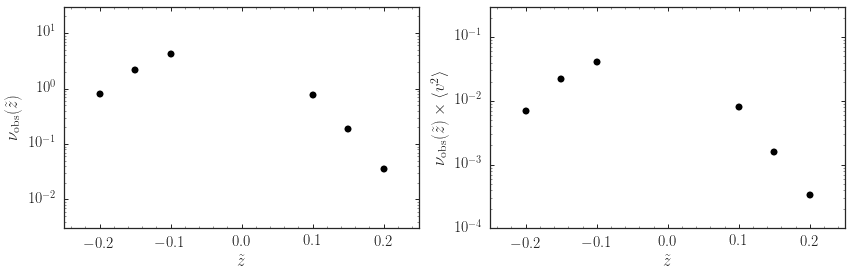

In [16]:
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,xtick_labelsize=15.,ytick_labelsize=15.)
figsize(12,4)
subplot(1,2,1)
bovy_plot.bovy_plot(z_obs,dens_obs,'ko',semilogy=True,
                   xlabel=r'$\tilde{z}$',ylabel=r'$\nu_{\mathrm{obs}}(\tilde{z})$',
                   xrange=[-.25,0.25],yrange=[0.003,30.],gcf=True)
subplot(1,2,2)
bovy_plot.bovy_plot(z_obs,densv2_obs,'ko',semilogy=True,
                   xlabel=r'$\tilde{z}$',ylabel=r'$\nu_{\mathrm{obs}}(\tilde{z})\times \langle v^2\rangle$',
                   xrange=[-.25,0.25],yrange=[0.0001,.3],gcf=True)
tight_layout()

These make sense, because the velocity dispersion is constant so $\nu\times\langle v^2\rangle$ is just a rescaling of $\nu$. Let's include these observables in the force of change for the weights.

In [17]:
def force_of_change_weights_v2(w_m2m,zsun_m2m,z_m2m,vz_m2m,
                               eps,mu,w_prior,
                               z_obs,densv2_obs,
                               h_m2m=h_obs,
                               deltav2_m2m=None):
    """Computes the force of change for all of the weights due to the velocity constraint"""
    deltav2_m2m_new= numpy.zeros_like(z_obs)
    Wij= numpy.zeros((len(z_obs),len(z_m2m)))
    for ii,zo in enumerate(z_obs):
        Wij[ii]= kernel(numpy.fabs(zo-z_m2m+zsun_m2m),h_m2m)
        deltav2_m2m_new[ii]= (numpy.sum(w_m2m*Wij[ii]*vz_m2m**2.)/len(z_m2m)-densv2_obs[ii])/densv2_obs[ii]
    if deltav2_m2m is None: deltav2_m2m= deltav2_m2m_new
    return (-eps*w_m2m*numpy.sum(numpy.tile(deltav2_m2m,(len(z_m2m),1)).T*Wij,axis=0)*vz_m2m**2.,deltav2_m2m_new)
def run_m2m_weights_wv2(w_init,A_init,phi_init,
                        omega_m2m,zsun_m2m,
                        z_obs,dens_obs,
                        step=0.001,nstep=1000,
                        eps=0.1,mu=1.,
                        h_m2m=0.02,
                        smooth=None,nodens=False):
    w_out= copy.deepcopy(w_init)
    Q_out= []
    if not smooth is None:
        # Smooth the constraints
        phi_now= phi_init
        z_m2m= A_init*numpy.cos(phi_now)
        vz_m2m= -A_init*omega_m2m*numpy.sin(phi_now) # unnecessary
        dens_init= compute_dens(z_m2m,zsun_m2m,z_obs,w=w_init)
        delta_m2m= (dens_init-dens_obs)/dens_obs
        densv2_init= compute_densv2(z_m2m,vz_m2m,zsun_m2m,z_obs,w=w_init)
        deltav2_m2m= (densv2_init-densv2_obs)/densv2_obs
    else:
        delta_m2m= None
        deltav2_m2m= None
    for ii in range(nstep):
        # Compute current (z,vz)
        phi_now= omega_m2m*ii*step+phi_init
        z_m2m= A_init*numpy.cos(phi_now)
        vz_m2m= -A_init*omega_m2m*numpy.sin(phi_now) # unnecessary
        fcw, delta_m2m_new= force_of_change_weights(w_out,zsun_m2m,
                                                    z_m2m,vz_m2m,
                                                    eps,mu,w_init,
                                                    z_obs,dens_obs,h_m2m=h_m2m,
                                                    delta_m2m=delta_m2m)
        fcwv2, deltav2_m2m_new= force_of_change_weights_v2(w_out,zsun_m2m,
                                                           z_m2m,vz_m2m,
                                                           eps,mu,w_init,
                                                           z_obs,densv2_obs,h_m2m=h_m2m,
                                                           deltav2_m2m=deltav2_m2m)
        w_out+= step*fcw*(1.-nodens)+step*fcwv2
        w_out/= numpy.sum(w_out)/len(A_init)
        w_out[w_out < 0.]= 10.**-16.
        if not smooth is None:
            Q_out.append(delta_m2m**2.*(1.-nodens)+deltav2_m2m**2.)
        else:
            Q_out.append(delta_m2m_new**2.*(1.-nodens)+deltav2_m2m_new**2.)
        # Increment smoothing
        if not smooth is None:
            delta_m2m+= step*smooth*(delta_m2m_new-delta_m2m)
            deltav2_m2m+= step*smooth*(deltav2_m2m_new-deltav2_m2m)
    return (w_out,numpy.array(Q_out))

Run without smoothing, just using the velocity constraint:

In [18]:
step= numpy.pi/3.*10.**-2.
nstep= 30000
eps= 10.**-1.
mu= 0.
h_m2m= 0.025
nodens= True
omega_m2m= omega_true
zsun_m2m= zsun_true
z_out= numpy.linspace(-0.3,0.3,101)
densv2_init= compute_densv2(z_m2m,vz_m2m,zsun_true,z_out,w_init)
w_out,Q= run_m2m_weights_wv2(w_init,A_m2m,phi_m2m,omega_m2m,zsun_m2m,
                             z_obs,dens_obs,nstep=nstep,step=step,mu=mu,eps=eps,h_m2m=h_m2m,nodens=nodens)

('Velocity dispersions: mock, fit', 0.099155676074897642, 0.10030158389758635)


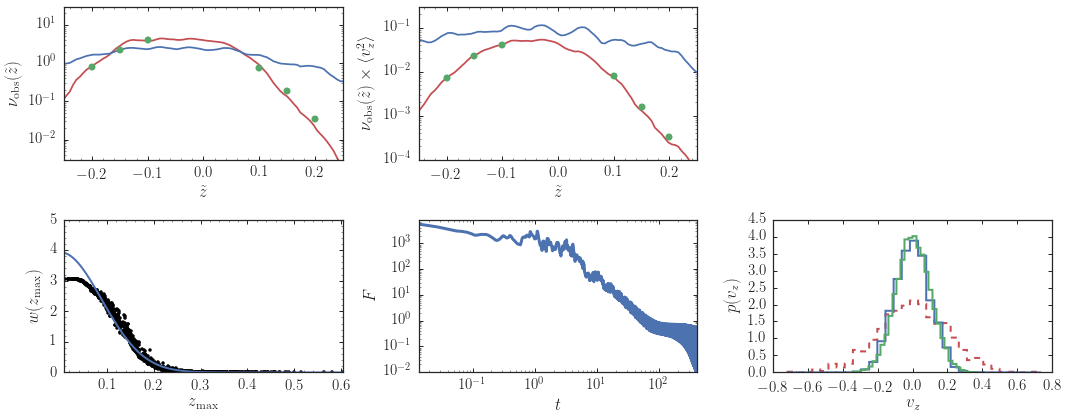

In [19]:
z_m2m= A_m2m*numpy.cos(phi_m2m+nstep*step*omega_m2m)
vz_m2m= -A_m2m*omega_m2m*numpy.sin(phi_m2m+nstep*step*omega_m2m)
z_out= numpy.linspace(-0.3,0.3,101)
dens_final= compute_dens(z_m2m,zsun_true,z_out,w_out)
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,xtick_labelsize=15.,ytick_labelsize=15.)
figsize(15,6)
subplot(2,3,1)
bovy_plot.bovy_plot(z_out,dens_init,'-',semilogy=True,
                   xlabel=r'$\tilde{z}$',ylabel=r'$\nu_{\mathrm{obs}}(\tilde{z})$',
                   xrange=[-.25,0.25],yrange=[0.003,30.],gcf=True)
bovy_plot.bovy_plot(z_obs,dens_obs,'o',semilogy=True,overplot=True)
bovy_plot.bovy_plot(z_out,dens_final,'-',semilogy=True,overplot=True,zorder=0)
subplot(2,3,2)
densv2_final= compute_densv2(z_m2m,vz_m2m,zsun_true,z_out,w_out)
bovy_plot.bovy_plot(z_out,densv2_init,'-',semilogy=True,
                   xlabel=r'$\tilde{z}$',ylabel=r'$\nu_{\mathrm{obs}}(\tilde{z})\times\langle v_z^2\rangle$',
                   xrange=[-.25,0.25],yrange=[0.0001,.3],gcf=True)
bovy_plot.bovy_plot(z_obs,densv2_obs,'o',semilogy=True,overplot=True)
bovy_plot.bovy_plot(z_out,densv2_final,'-',semilogy=True,overplot=True,zorder=0)
subplot(2,3,4)
bovy_plot.bovy_plot(A_m2m,w_out,'k.',xlabel=r'$z_{\mathrm{max}}$',ylabel=r'$w(z_{\mathrm{max}})$',
                   yrange=[0.,5.],gcf=True)
sindx= numpy.argsort(A_m2m)
w_expect= numpy.exp((A_m2m[sindx]*omega_m2m)**2./2.*(1./sigma_init**2.-1./sigma_true**2.))
w_expect/= numpy.sum(w_expect)/len(w_expect)
plot(A_m2m[sindx],w_expect,lw=2.)
subplot(2,3,5)
bovy_plot.bovy_plot(numpy.linspace(0.,1.,nstep)*nstep*step*omega_m2m,numpy.sum(Q,axis=1),lw=3.,
                   loglog=True,xlabel=r'$t$',ylabel=r'$F$',gcf=True)
subplot(2,3,6)
_= hist(vz_m2m,weights=w_out,histtype='step',lw=2.,normed=True,bins=31,zorder=1)
_= hist(vz_mock,histtype='step',lw=2.,normed=True,bins=31,zorder=2)
_= hist(vz_m2m,histtype='step',lw=2.,normed=True,bins=31,ls='--',zorder=0)
xlabel(r'$v_z$')
ylabel(r'$p(v_z)$')
print("Velocity dispersions: mock, fit",numpy.std(vz_mock),\
      numpy.sqrt(numpy.sum(w_out*(vz_m2m-numpy.sum(w_out*vz_m2m)/numpy.sum(w_out))**2.)/numpy.sum(w_out)))
tight_layout()

Run without smoothing, both the velocity and density constraint:

In [20]:
step= numpy.pi/3.*10.**-2.
nstep= 30000
eps= 10.**-1.
mu= 0.
h_m2m= 0.025
nodens= False
omega_m2m= omega_true
zsun_m2m= zsun_true
z_out= numpy.linspace(-0.3,0.3,101)
densv2_init= compute_densv2(z_m2m,vz_m2m,zsun_true,z_out,w_init)
w_out,Q= run_m2m_weights_wv2(w_init,A_m2m,phi_m2m,omega_m2m,zsun_m2m,
                             z_obs,dens_obs,nstep=nstep,step=step,mu=mu,eps=eps,h_m2m=h_m2m,nodens=nodens)

('Velocity dispersions: mock, fit', 0.099155676074897642, 0.098953428163997895)


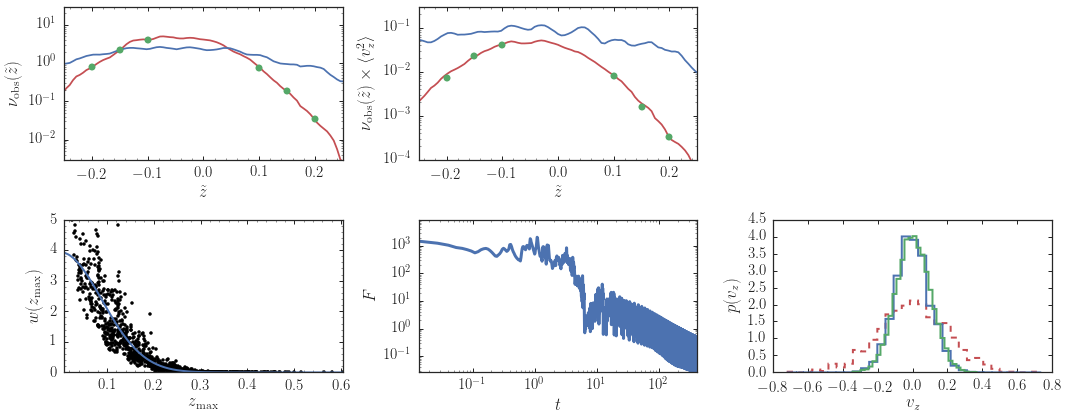

In [21]:
z_m2m= A_m2m*numpy.cos(phi_m2m+nstep*step*omega_m2m)
vz_m2m= -A_m2m*omega_m2m*numpy.sin(phi_m2m+nstep*step*omega_m2m)
z_out= numpy.linspace(-0.3,0.3,101)
dens_final= compute_dens(z_m2m,zsun_true,z_out,w_out)
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,xtick_labelsize=15.,ytick_labelsize=15.)
figsize(15,6)
subplot(2,3,1)
bovy_plot.bovy_plot(z_out,dens_init,'-',semilogy=True,
                   xlabel=r'$\tilde{z}$',ylabel=r'$\nu_{\mathrm{obs}}(\tilde{z})$',
                   xrange=[-.25,0.25],yrange=[0.003,30.],gcf=True)
bovy_plot.bovy_plot(z_obs,dens_obs,'o',semilogy=True,overplot=True)
bovy_plot.bovy_plot(z_out,dens_final,'-',semilogy=True,overplot=True,zorder=0)
subplot(2,3,2)
densv2_final= compute_densv2(z_m2m,vz_m2m,zsun_true,z_out,w_out)
bovy_plot.bovy_plot(z_out,densv2_init,'-',semilogy=True,
                   xlabel=r'$\tilde{z}$',ylabel=r'$\nu_{\mathrm{obs}}(\tilde{z})\times\langle v_z^2\rangle$',
                   xrange=[-.25,0.25],yrange=[0.0001,.3],gcf=True)
bovy_plot.bovy_plot(z_obs,densv2_obs,'o',semilogy=True,overplot=True)
bovy_plot.bovy_plot(z_out,densv2_final,'-',semilogy=True,overplot=True,zorder=0)
subplot(2,3,4)
bovy_plot.bovy_plot(A_m2m,w_out,'k.',xlabel=r'$z_{\mathrm{max}}$',ylabel=r'$w(z_{\mathrm{max}})$',
                   yrange=[0.,5.],gcf=True)
sindx= numpy.argsort(A_m2m)
w_expect= numpy.exp((A_m2m[sindx]*omega_m2m)**2./2.*(1./sigma_init**2.-1./sigma_true**2.))
w_expect/= numpy.sum(w_expect)/len(w_expect)
plot(A_m2m[sindx],w_expect,lw=2.)
subplot(2,3,5)
bovy_plot.bovy_plot(numpy.linspace(0.,1.,nstep)*nstep*step*omega_m2m,numpy.sum(Q,axis=1),lw=3.,
                   loglog=True,xlabel=r'$t$',ylabel=r'$F$',gcf=True)
subplot(2,3,6)
_= hist(vz_m2m,weights=w_out,histtype='step',lw=2.,normed=True,bins=31,zorder=1)
_= hist(vz_mock,histtype='step',lw=2.,normed=True,bins=31,zorder=2)
_= hist(vz_m2m,histtype='step',lw=2.,normed=True,bins=31,ls='--',zorder=0)
xlabel(r'$v_z$')
ylabel(r'$p(v_z)$')
print("Velocity dispersions: mock, fit",numpy.std(vz_mock),\
      numpy.sqrt(numpy.sum(w_out*(vz_m2m-numpy.sum(w_out*vz_m2m)/numpy.sum(w_out))**2.)/numpy.sum(w_out)))
tight_layout()

## Also fit for the potential during the optimization

Now we will attempt to simultaneously optimize the potential and the weights using the combined density data. For this, we need to write down the force of change for the potential parameter:

In [22]:
def force_of_change_omega(w_m2m,zsun_m2m,omega_m2m,
                          z_m2m,vz_m2m,
                          eps,mu,w_prior,
                          z_obs,dens_obs,
                          h_m2m=0.02,
                          delta_m2m=None,deltav2_m2m=None):
    """Computes the force of change for all of the weights"""
    out= 0.
    for ii,zo in enumerate(z_obs):
        Wij= numpy.zeros((len(z_obs),len(z_m2m)))
        dWij= kernel_deriv(numpy.fabs(zo-z_m2m+zsun_m2m),h_m2m)*numpy.sign(zo-z_m2m+zsun_m2m)
        # density part
        out+= delta_m2m[ii]*numpy.sum(w_m2m*dWij*vz_m2m/omega_m2m)/len(z_m2m)
        # velocity part 1
        out+= deltav2_m2m[ii]*numpy.sum(w_m2m*vz_m2m**3.*dWij/omega_m2m)/len(z_m2m)
        # velocity part 2
        out+= -2.*deltav2_m2m[ii]*numpy.sum(w_m2m*vz_m2m*Wij*omega_m2m*z_m2m)/len(z_m2m)
    return -eps*out
def run_m2m_weights_zsun(w_init,A_init,phi_init,
                        omega_m2m,zsun_m2m,
                        z_obs,dens_obs,
                        step=0.001,nstep=1000,
                        eps=0.1,eps_omega=0.001,mu=1.,
                        h_m2m=0.02,
                        smooth=None):
    w_out= copy.deepcopy(w_init)
    Q_out= []
    if not smooth is None:
        # Smooth the constraints
        phi_now= phi_init
        z_m2m= A_init*numpy.cos(phi_now)
        vz_m2m= -A_init*omega_m2m*numpy.sin(phi_now) # unnecessary
        dens_init= compute_dens(z_m2m,zsun_m2m,z_obs,w=w_init)
        delta_m2m= (dens_init-dens_obs)/dens_obs
        densv2_init= compute_densv2(z_m2m,vz_m2m,zsun_m2m,z_obs,w=w_init)
        deltav2_m2m= (densv2_init-densv2_obs)/densv2_obs
    else:
        delta_m2m= None
        deltav2_m2m= None
    z_m2m= A_init*numpy.cos(phi_init)
    vz_m2m= -A_init*omega_m2m*numpy.sin(phi_init)
    for ii in range(nstep):
        # Compute current (z,vz)
        phi_prev= numpy.arctan2(vz_m2m,-z_m2m*omega_m2m)
        A_now= numpy.sqrt(z_m2m**2.+vz_m2m**2./omega_m2m**2.)
        phi_now= phi_prev+omega_m2m*step
        z_m2m= A_now*numpy.cos(phi_now)
        vz_m2m= -A_now*omega_m2m*numpy.sin(phi_now)
        fcw, delta_m2m_new= force_of_change_weights(w_out,zsun_m2m,
                                                    z_m2m,vz_m2m,
                                                    eps,mu,w_init,
                                                    z_obs,dens_obs,h_m2m=h_m2m,
                                                    delta_m2m=delta_m2m)
        fcwv2, deltav2_m2m_new= force_of_change_weights_v2(w_out,zsun_m2m,
                                                           z_m2m,vz_m2m,
                                                           eps,mu,w_init,
                                                           z_obs,densv2_obs,h_m2m=h_m2m,
                                                           deltav2_m2m=deltav2_m2m)
        if smooth is None:
            fcomega= force_of_change_omega(w_out,zsun_m2m,omega_m2m,
                                           z_m2m,vz_m2m,
                                           eps_omega,mu,w_init,
                                           z_obs,dens_obs,h_m2m=h_m2m,
                                           delta_m2m=delta_m2m_new,deltav2_m2m=deltav2_m2m_new)
        else:
            fcomega= force_of_change_omega(w_out,zsun_m2m,omega_m2m,
                                           z_m2m,vz_m2m,
                                           eps_omega,mu,w_init,
                                           z_obs,dens_obs,h_m2m=h_m2m,
                                           delta_m2m=delta_m2m_new,deltav2_m2m=deltav2_m2m)
        #print(fcz)
        w_out+= step*fcw
        w_out/= numpy.sum(w_out)/len(A_init)
        w_out[w_out < 0.]= 10.**-16.
        omega_m2m+= step*fcomega
        Q_out.append(delta_m2m_new**2.+deltav2_m2m_new**2.)
        # Increment smoothing
        if not smooth is None:
            delta_m2m= step*smooth*(delta_m2m_new-delta_m2m)
            deltav2_m2m= step*smooth*(deltav2_m2m_new-deltav2_m2m)
    return ((w_out,omega_m2m,z_m2m,vz_m2m),numpy.array(Q_out))

In [23]:
step= numpy.pi/3.*10.**-2.
nstep= 100000
eps= 10.**-1.
eps_omega= eps/3.
mu= 0.
h_m2m= 0.025
omega_m2m= omega_true-0.5
zsun_m2m= zsun_true
(w_out,omega_out,z_m2m,vz_m2m),Q= run_m2m_weights_zsun(w_init,A_m2m,phi_m2m,omega_m2m,zsun_m2m,
                                          z_obs,dens_obs,nstep=nstep,step=step,mu=mu,eps=eps,h_m2m=h_m2m,
                                          eps_omega=eps_omega)

('Velocity dispersions: mock, fit', 0.099155676074897642, 0.097274973974289025)
('omega: fit, starting point', 1.2650179160399173, 0.8)


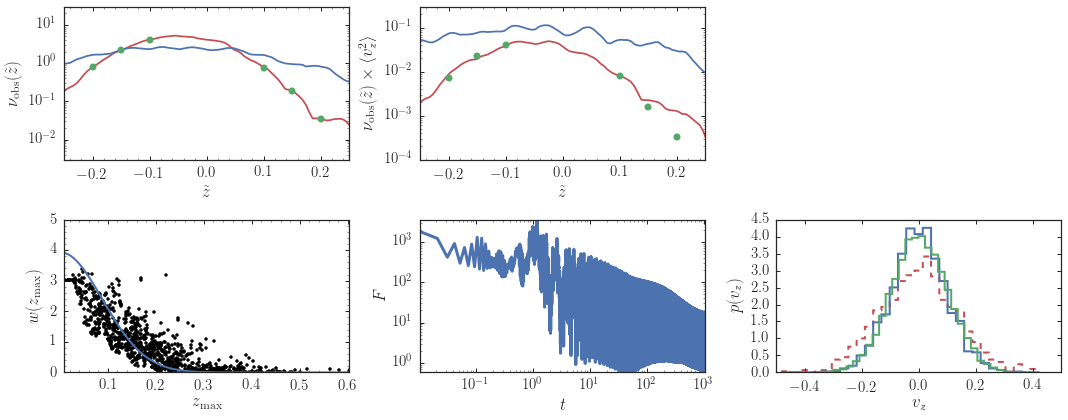

In [24]:
z_out= numpy.linspace(-0.3,0.3,101)
dens_final= compute_dens(z_m2m,zsun_true,z_out,w_out)
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,xtick_labelsize=15.,ytick_labelsize=15.)
figsize(15,6)
subplot(2,3,1)
bovy_plot.bovy_plot(z_out,dens_init,'-',semilogy=True,
                   xlabel=r'$\tilde{z}$',ylabel=r'$\nu_{\mathrm{obs}}(\tilde{z})$',
                   xrange=[-.25,0.25],yrange=[0.003,30.],gcf=True)
bovy_plot.bovy_plot(z_obs,dens_obs,'o',semilogy=True,overplot=True)
bovy_plot.bovy_plot(z_out,dens_final,'-',semilogy=True,overplot=True,zorder=0)
subplot(2,3,2)
densv2_final= compute_densv2(z_m2m,vz_m2m,zsun_true,z_out,w_out)
bovy_plot.bovy_plot(z_out,densv2_init,'-',semilogy=True,
                   xlabel=r'$\tilde{z}$',ylabel=r'$\nu_{\mathrm{obs}}(\tilde{z})\times\langle v_z^2\rangle$',
                   xrange=[-.25,0.25],yrange=[0.0001,.3],gcf=True)
bovy_plot.bovy_plot(z_obs,densv2_obs,'o',semilogy=True,overplot=True)
bovy_plot.bovy_plot(z_out,densv2_final,'-',semilogy=True,overplot=True,zorder=0)
subplot(2,3,4)
bovy_plot.bovy_plot(A_m2m,w_out,'k.',xlabel=r'$z_{\mathrm{max}}$',ylabel=r'$w(z_{\mathrm{max}})$',
                   yrange=[0.,5.],gcf=True)
sindx= numpy.argsort(A_m2m)
w_expect= numpy.exp((A_m2m[sindx]*omega_true)**2./2.*(1./sigma_init**2.-1./sigma_true**2.))
w_expect/= numpy.sum(w_expect)/len(w_expect)
plot(A_m2m[sindx],w_expect,lw=2.)
subplot(2,3,5)
bovy_plot.bovy_plot(numpy.linspace(0.,1.,nstep)*nstep*step,numpy.sum(Q,axis=1),lw=3.,
                   loglog=True,xlabel=r'$t$',ylabel=r'$F$',gcf=True)
subplot(2,3,6)
_= hist(vz_m2m,weights=w_out,histtype='step',lw=2.,normed=True,bins=31,zorder=1)
_= hist(vz_mock,histtype='step',lw=2.,normed=True,bins=31,zorder=2)
_= hist(vz_m2m,histtype='step',lw=2.,normed=True,bins=31,ls='--',zorder=0)
xlabel(r'$v_z$')
ylabel(r'$p(v_z)$')
print("Velocity dispersions: mock, fit",numpy.std(vz_mock),\
      numpy.sqrt(numpy.sum(w_out*(vz_m2m-numpy.sum(w_out*vz_m2m)/numpy.sum(w_out))**2.)/numpy.sum(w_out)))
tight_layout()
print("omega: fit, starting point",omega_out, omega_m2m)